In [19]:
from src.database import DatabaseXRD,snip,Phase,MixPhase
from src.gaussnewton import GaussNewton
from numpy import newaxis,save,loadtxt,diag,histogram,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import imshow,plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

from src.spectra import Spectra
from src.xrd_data import DataXRD

In [2]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]
lazurite = database['Lazurite'][0]

In [3]:
xrd_data = DataXRD().load_h5('/home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M491/ProfiloXRD/data.h5')

Loading: /home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M491/ProfiloXRD/data.h5
Load inverted
Load convoluted


In [4]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

In [5]:
files = glob('Profilo/Lazurite/roi*.dat')
phase = MixPhase([hydrocerussite])

xrd_gauss_newton = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('/home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M0795/CappelloGialloXRD/calibration.ini')
    spectra.convolve(4).raw_snip(m=16)

    xrd_gauss_newton += [GaussNewton(phase,spectra)]

(0.0, 1280.0)

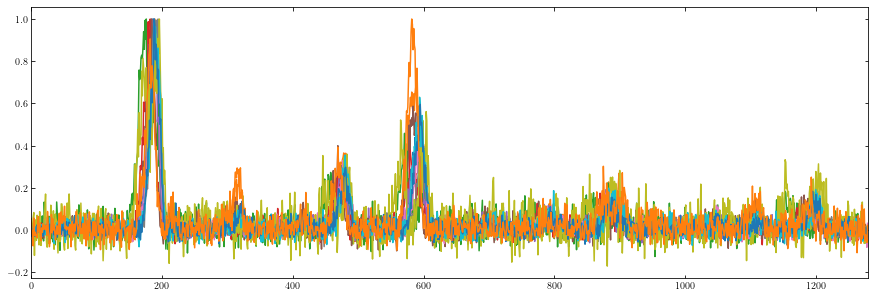

In [6]:
figure(figsize=(15,5))
for g in xrd_gauss_newton:
    plot(g.spectra.intensity)
xlim(0,1280)

[-1172.9522594182133, 51.000000000000284, 1915.0353144813905] 16.487295257780954
[-1191.9006541892575, 50.99999999999997, 2004.298069142338] 15.633903640779728
[-1164.1502283503144, 50.999999999999915, 1835.0321727201688] 21.70126916915091
[-1220.589319945363, 50.99999999999988, 2123.4617396604285] 13.5087513202708
[-1189.3528000109943, 50.99999999999941, 1980.5254699970073] 15.079972525802276
[-1176.8130576911276, 50.99999999999986, 1961.3232929643575] 13.699917250844925
[-1223.0759468616207, 51.00000000000016, 2092.7092957078353] 9.391903993697621
[-1174.560847427587, 50.999999999999936, 1907.69520754353] 12.95985836544768
[-1172.159601495774, 50.99999999999968, 1867.9181559856597] 26.411540197112245
[-1173.5638469693, 51.00000000000041, 1914.8963970668167] 14.005854937961173
[-1178.1901438523655, 50.999999999999865, 1930.332997829508] 12.32584435635987
[-1175.8976180964685, 50.99999999999997, 1953.0082016424715] 12.312435277902702


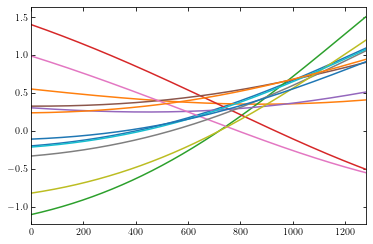

In [7]:
x = arange(1280)
    
for g in xrd_gauss_newton:
    
    g.spectra.opt = [-1186.106076632754, 51., 1954.6937605682037]
    
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()
    for _ in range(2):
        g.calibration_nobeta(alpha=0.5)
        g.opt = g.spectra.opt.copy()

    print(g.spectra.opt,g.dz)
    
    opt = g.spectra.opt
    opt_file = g.spectra.opt_file
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)

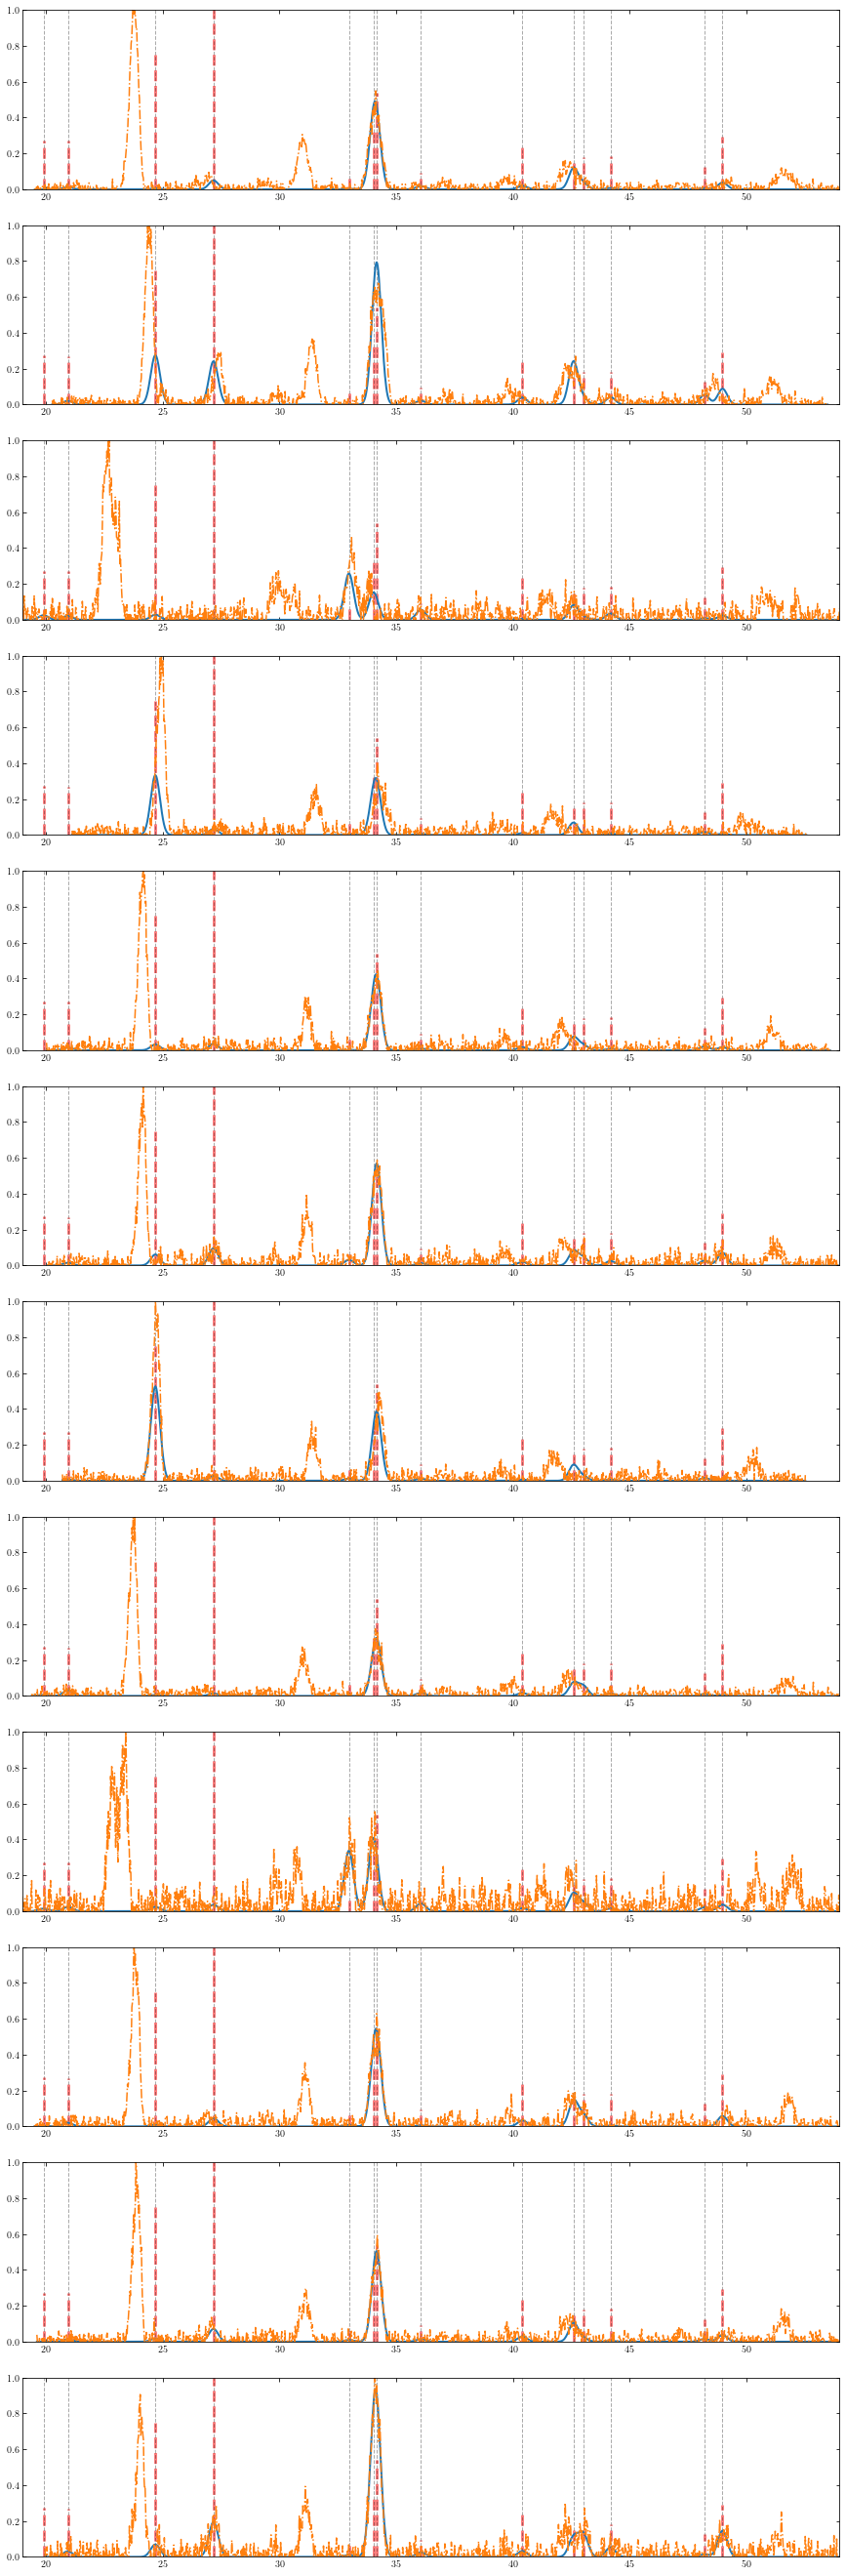

In [10]:
%matplotlib inline
fig,ax = subplots(len(xrd_gauss_newton),1,figsize = (15,48))

for i,g in enumerate(xrd_gauss_newton):
    
    g.spectra.opt = g.opt.copy()
    s = g.spectra
    
    ax[i].vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
    ax[i].plot(g.theta,g.z,'-',lw=2)
    ax[i].plot(s.theta,s.intensity,'-.')
    ax[i].vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)
    
    ax[i].vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

In [24]:
%%time

data = xrd_data.inverted.reshape(-1,1280)
profilo_gauss_newton = []

for d in data[:]:
    spectra = Spectra()
    spectra.from_array(d)
    spectra.opt[:] = array([-1185.2366578999117, 50.99999999999997, 1955.6511408474753])
    
    spectra.convolve(4).raw_snip(m=32)
    
    g = GaussNewton(phase,spectra)
    
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()
    for _ in range(2):
        g.calibration_nobeta(alpha=0.5)
        g.opt = g.spectra.opt.copy()

    #print(g.spectra.opt)
    
    profilo_gauss_newton += [g]
    

CPU times: user 7min 17s, sys: 57.9 ms, total: 7min 17s
Wall time: 7min 17s


In [ ]:
%%time
for g in profilo_gauss_newton:
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()

In [25]:
out = array([g.dz for g in profilo_gauss_newton])
out = out.reshape(95,170)

In [28]:
out = array([g.dz for g in profilo_gauss_newton])
out = out.reshape(95,170)
save('Hydrocerussite.npy',out)

a = array([g.opt[0] for g in profilo_gauss_newton])
a = a.reshape(95,170)
a.max(),a.argmin()
save('Hydrocerussite_a.npy',a)

In [26]:
out.shape,xrd_data.inverted.shape

((95, 170), (95, 170, 1280))

In [27]:
out.max(),out.argmin()
save('hydrocerussite.npy',out)

0.182062337059002


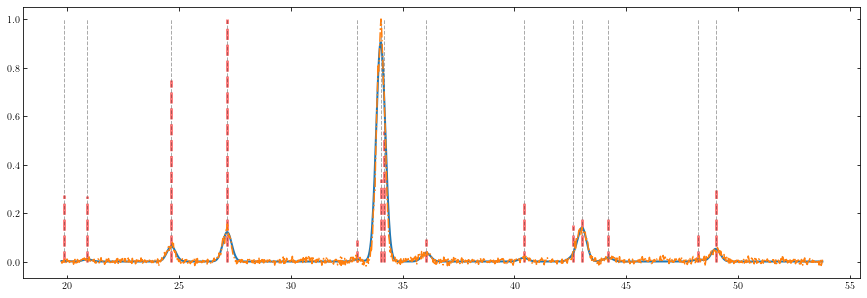

In [14]:
figure(figsize=(15,5))
g = profilo_gauss_newton[out.argmin()]
s =g.spectra

for _ in range(4):
    g.calibration_nobeta()
print(g.dz)
    
vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(s.theta,s.intensity,'-.')
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)

vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)

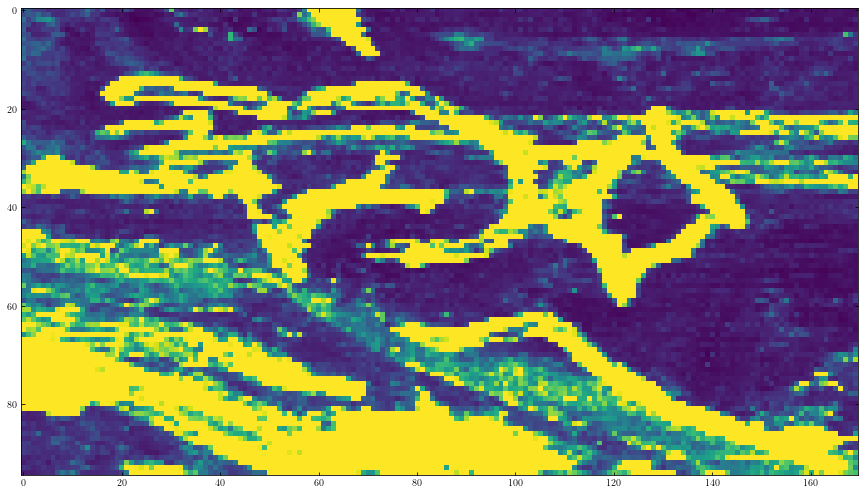

In [18]:
figure(figsize=(15,15))
imshow(out[::-1],vmax=5)

In [ ]:
a = array([g.opt[0] for g in profilo_gauss_newton])
a = a.reshape(95,170)
a.max(),a.min()

In [ ]:
figure(figsize=(15,15))
imshow(a[::-1])